# YOLOv3 Keras API Image Object Detection

In this notebook I want to implement simple object detection with Keras of some JPEG images in our training set. I use a pretrained (MSCOCO dataset) YOLOv3 model.

This kernel is mainly based on https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras and adapted for Lyft 3D Object Detection for Autonomous Driving challenge. I highly advise you to read to throught the blog for deeper understanding, and giving the original blogger the props.

Please note that the model hasn't been fine tuned, or trained myself. The following implementation should serve the purpose of facilitating to get started with the current challenge.
I don't know how relevant object detection with images is, in a 3D object detection challenge, as the LiDAR data is not regarded.

If this Kernel helped you in any way, give it an upvote (such that I can increasy my online self-esteem...)$

In [1]:
import os
# based on https://github.com/experiencor/keras-yolo3
import pandas as pd
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
print(os.listdir('/kaggle/input/'))
DATA_PATH = '/kaggle/input/drone-dataset-with-steering-angle-2/final_example.csv'

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

['model-good', 'drone-dataset-with-steering-angle-2', 'cat-and-dog', 'large-car', 'ourstreet']


In [2]:
os.listdir('/kaggle/input/ourstreet/Screen Shot 2020-02-22 at 4.15.38 PM.png')

NotADirectoryError: [Errno 20] Not a directory: '/kaggle/input/ourstreet/Screen Shot 2020-02-22 at 4.15.38 PM.png'

## Visualization Functions
The underlying class and functions are used to show the predictions of the detected objects in the original picture.

In [3]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle
 
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score
 
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height
 
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores
 
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    # show the plot
    pyplot.show()

## Load YOLOv3 Model
As the weights have now been saved in an h5 file (which can be found in the output files), we load it into the model.

In [4]:
# load yolov3 model
from keras.models import load_model
model = load_model('/kaggle/input/model-good/model.h5')

/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Predict Objects in first 10 training images
We now try to check if our implementation works, by predicting the objects in the first ten images of the training set.

In [5]:
# Parameters used in the Dataset, on which YOLOv3 was pretrained
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# define the expected input shape for the model
WIDTH, HEIGHT = 416, 416

# define the probability threshold for detected objects
class_threshold = 0.7

In [6]:
import os
from matplotlib import pyplot as plt

In [7]:
from numpy import expand_dims
from keras.preprocessing.image import load_img, img_to_array

# load and prepare an image
def load_image_pixels(filename, shape):
    '''
    Function preprocess the images to 416x416, which is the standard input shape for YOLOv3, 
    and also keeps track of the originl shape, which is later used to draw the boxes.
    
    paramters:
    filename {String}: path to the image
    shape {tuple}: shape of the input dimensions of the network
    
    returns:
    image {PIL}: image of shape 'shape'
    width {int}: original width of the picture
    height {int}: original height of the picture
    '''
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    
    # convert to numpy array
    image = img_to_array(image)
    
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

Iterate through the pictures and detect the objects.

In [8]:
images = pd.read_csv(DATA_PATH)
images = images['frame_id'].tolist()

In [9]:
def predict_image(filepath, labels):
    image, image_w, image_h = load_image_pixels(filepath, (WIDTH, HEIGHT))
    yhat = model.predict(image)
    
    boxes = list()
    for i in range(len(yhat)):
        # decode the output of the network
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, HEIGHT, WIDTH)

    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, image_h, image_w, HEIGHT, WIDTH)

    # suppress non-maximal boxes
    do_nms(boxes, 0.5)

    # get the details of the detected objects
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    
    return v_boxes, v_labels, v_scores, image_h, image_w
    

In [10]:
DATA_MAIN = '/kaggle/input/drone-dataset-with-steering-angle-2/center'

In [11]:
import math
from scipy.integrate import quad

def function_x(x, width,maxi, imp):
    w = width/2
    b = math.sqrt(4*math.log(imp))/w
    temp = maxi*(math.e**(-1*(b*(x-w))**2))
    return temp

def function_y(y, h, maxi, i_e, i_m):
    C = maxi/(i_e * i_m)
    a = h/(4*C*(i_e*i_m - 1))
    B = (1 + math.sqrt(1 - (i_e - 1)/(i_e*i_m - 1)))/(2*a)
    A = -1*(B**2/(4*C*(i_e*i_m - 1)))
    return A*y**2 + B*y + C

def importance_box(size, bBox, maxi, imp_x, imp_y_e, imp_y_m):
    x1 = quad(lambda x: function_x(x, size[0], maxi, imp_x ), bBox.xmin, bBox.xmax)
    x2 = quad(lambda x: function_x(x, size[0], maxi, imp_x ), 0, size[0])
    x = x1[0]/x2[0]
    y1 = quad(lambda y: function_y(y, size[1], maxi, imp_y_e, imp_y_m ), bBox.ymin, bBox.ymax)
    y2 = quad(lambda y: function_y(y, size[1], maxi, imp_y_e, imp_y_m ), 0, size[1])
    y = y1[0]/y2[0]
    print("X is " , x , " and y is ", y)
    return max(x, y)

def importance_img(size, v_boxes, maxi, imp_x, imp_y_e, imp_y_m):
    c = 0
    for box in v_boxes:
        c += importance_box(size, box, maxi, imp_x, imp_y_e, imp_y_m)**1.5
    return c**0.66


In [12]:
print(1)

1


c = 0
mod = 50
for file in images:
    if(c > 15*mod):
        break
    if(c%mod != 0):
        c += 1
        continue
    photo_filename = DATA_MAIN + "/" + str(file) + ".jpg"
    # define the labels (Filtered only the ones relevant for this task, which were used in pretraining the YOLOv3 model)
    labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck","boat", "tree", "dogs", "cat"]

    # get the details of the detected objects
    v_boxes, v_labels, v_scores, image_h, image_w = predict_image(photo_filename, labels)

    for i in range(len(v_boxes)):
        print(v_labels[i], v_scores[i])
    print("Probability of collision: " , importance_img((image_w, image_h), v_boxes, 10, 1.5, 3, 1.1))

# draw what we found
    draw_boxes(photo_filename, v_boxes, v_labels, v_scores)
    c += 1

car 83.20010304450989
car 79.70468997955322
car 72.54575490951538
car 94.77418065071106
car 96.959787607193
car 88.01559209823608
car 83.40470790863037
car 87.5169038772583
car 99.42863583564758
car 99.64192509651184
X is  0.02806412251608686  and y is  0.02427886745454857
X is  0.022776618090017152  and y is  0.023398024749389883
X is  0.018924710384878647  and y is  0.0152627606738989
X is  0.06139099156138391  and y is  0.04806919565110449
X is  0.04557912282462742  and y is  0.0389060749139761
X is  0.03045433978322976  and y is  0.02977350258199505
X is  0.0458353621133634  and y is  0.04621862169432399
X is  0.04590353251923197  and y is  0.034387824152794816
X is  0.0779934592418537  and y is  0.0564633918195371
X is  0.10890980774175173  and y is  0.08237652488166435
Probability of collision:  0.24489507466182867


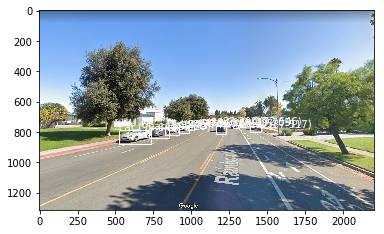

In [13]:

photo_filename = "/kaggle/input/ourstreet/Screen Shot 2020-02-22 at 4.15.38 PM.png"
    # define the labels (Filtered only the ones relevant for this task, which were used in pretraining the YOLOv3 model)
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck","boat", "tree", "dogs", "cat"]

# get the details of the detected objects
v_boxes, v_labels, v_scores, image_h, image_w = predict_image(photo_filename, labels)

for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])
print("Probability of collision: " , importance_img((image_w, image_h), v_boxes, 10, 1.5, 3, 1.1))

# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)